# Introduction


This notebook uses the openkmi package to calculate the Penman-Monteith evapotranspiration and the corresponding rainfall deficit.

# Initialize the package

First load the modules we will use

In [27]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd   
from openkmi.point_obs import Synop
import numpy as np
import pyeto
from pyeto import fao
import datetime

Then initialize the package

In [28]:
kmi = Synop()

In [29]:
stations = kmi.get_stations().set_index('code')
stations = stations[~stations.index.duplicated(keep='first')]

stations

,the_geom,altitude,name,date_begin,date_end
code,,,,,
6490,POINT (50.478615 5.909864),482.0,SPA (AERODROME),1952-01-01T00:00:00,NaN
6476,POINT (50.038875 5.403753),557.0,SAINT-HUBERT,1952-01-01T00:00:00,NaN
6414,POINT (50.90398 3.121692),24.8,BEITEM,2003-08-01T07:00:00,NaN
6418,POINT (51.347375 3.201846),12.1,ZEEBRUGGE,2005-12-01T00:00:00,NaN
6438,POINT (51.324802 4.363798),4.0,STABROEK,2012-08-05T00:00:00,NaN
6446,POINT (50.796862 4.357871),100.6,UCCLE-UKKEL,2001-08-23T00:00:00,2003-12-09T08:00:00
6447,POINT (50.796862 4.357871),100.6,UCCLE-UKKEL,2003-12-01T00:00:00,NaN
6477,POINT (50.915458 5.450296),39.3,DIEPENBEEK,2004-06-29T00:00:00,NaN
6478,POINT (50.645282 5.458738),178.0,BIERSET,1952-01-01T00:00:00,NaN


Let's choose a station for which to do the analysis:

In [30]:
#Ukkel:
station_code = '6447'

# Fetch rainfall data

In [31]:
from owslib.fes import PropertyIsEqualTo
custom_filt = PropertyIsEqualTo(propertyname='precip_range', literal='2')
df_r = kmi.get_data(station_code, start_date='1950-01-01T00:00:00', end_date= datetime.datetime.now().strftime('%Y-%m-%dT00:00:00'),
                    parameter_list=['precip_quantity'], custom_filter=custom_filt)
df_r = df_r[df_r.index.hour.isin([6,18])]

In [32]:
df_r = df_r.resample('d').sum()
# We assume values over 200mm / day are not realistic
df_r.loc[df_r['precip_quantity'] > 200, 'precip_quantity']= 0

<AxesSubplot:xlabel='timestamp'>

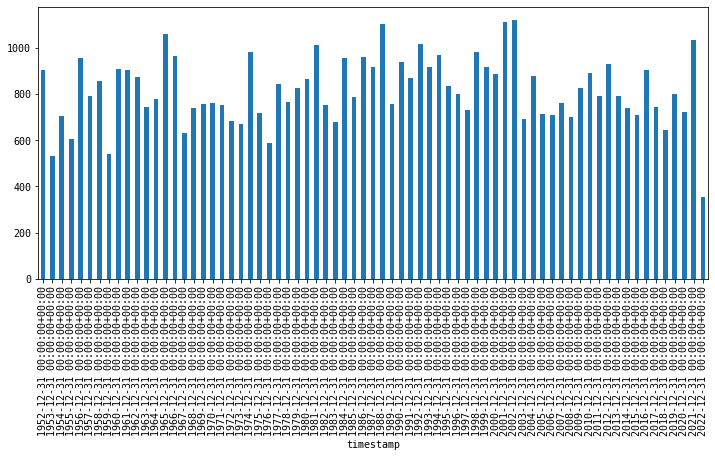

In [33]:
fig, ax = plt.subplots(figsize=(12,5))
df_r.resample('y').sum().plot.bar(ax=ax, legend=False)

# Calculate Penman-Monteith

We estimate reference evapotranspiration (ETo) from a hypothetical short grass reference surface using the FAO-56 Penman-Monteith equation. More info on the Penman-Monteith equation can be found here:

https://www.fao.org/3/x0490e/x0490e08.htm#TopOfPage

Inputting all the equations ourselves would take a lot of time. Luckily there is a nice package that we can use: pyeto:

https://pyeto.readthedocs.io/en/latest/

## Collect and validate input data

In [34]:
df = kmi.get_data(station_code, start_date='1950-01-01T00:00:00', end_date= datetime.datetime.now().strftime('%Y-%m-%dT00:00:00'),
                    parameter_list=['temp', 'humidity_relative', 'wind_speed', 'sun_duration_24hours', 'pressure'])

In [35]:
# Some RH's are larger than 100 which obviously is not possible:
df.loc[df['humidity_relative'] > 100, 'humidity_relative'] = 100

In [36]:
# Transform to daily mean, min and max values
df_d = df.resample('d').mean()[['temp', 'wind_speed', 'sun_duration_24hours']]
df_d['tmin'] = df.resample('d').min()['temp']
df_d['tmax'] = df.resample('d').max()['temp']
df_d['rh_min'] = df.resample('d').min()['humidity_relative']
df_d['rh_max'] = df.resample('d').max()['humidity_relative']
# Sun duration is in minutes while we need it in hours
df_d['sun_duration_24hours'] = df_d['sun_duration_24hours'] / 60
df_d['doy'] = df_d.index.dayofyear

In [37]:
# Filling some "smaller" gaps
for c in ['wind_speed', 'temp', 'tmin', 'tmax']:
    print(f'Use linear interpolation for {c} to fill {df_d[df_d[c].isna()].shape[0]} values')
    df_d[c] = df_d[c].interpolate()

Use linear interpolation for wind_speed to fill 147 values
Use linear interpolation for temp to fill 4 values
Use linear interpolation for tmin to fill 4 values
Use linear interpolation for tmax to fill 4 values


In [38]:
df_d.describe()

,temp,wind_speed,sun_duration_24hours,tmin,tmax,rh_min,rh_max,doy
count,25754.000000,25754.000000,2743.000000,25754.000000,25754.000000,17319.000000,17319.000000,25754.000000
mean,10.364889,3.463117,4.528995,7.280075,13.639774,61.628106,93.054318,182.481517
std,6.390919,1.601514,4.277999,5.771726,7.345155,16.647662,7.425517,105.433872
min,-13.875000,0.000000,0.000000,-16.200000,-12.000000,6.409500,41.500000,1.000000
25%,5.693750,2.312500,0.400000,3.000000,8.000000,49.363400,90.200000,91.000000
50%,10.527083,3.187500,3.533333,7.700000,13.800000,61.900000,94.134200,182.000000
75%,15.250000,4.337500,7.733333,12.000000,19.000000,74.600000,100.000000,274.000000
max,29.975000,15.444444,14.800000,23.700000,39.500000,100.000000,100.000000,366.000000


In [39]:
for c in df_d.columns:
    print(f'first date for {c} = {df_d[c].first_valid_index()}')

first date for temp = 1952-01-01 00:00:00+00:00
first date for wind_speed = 1952-01-01 00:00:00+00:00
first date for sun_duration_24hours = 2015-01-01 00:00:00+00:00
first date for tmin = 1952-01-01 00:00:00+00:00
first date for tmax = 1952-01-01 00:00:00+00:00
first date for rh_min = 1975-02-01 00:00:00+00:00
first date for rh_max = 1975-02-01 00:00:00+00:00
first date for doy = 1952-01-01 00:00:00+00:00


Important to note that for sun_duration and RH we only have data from 2015 and 1975 respectively. So if we want a historical reference we need to take that into acccount.

## Calculation

In [40]:
# This function uses pyeto to calculate the penman-monteith evp for Uccle
def get_montheith_evp(tmin, tmax, rh_min, rh_max, tmean, sunshine_hours, day_of_year, ws, altitude=100, lat=50.48):
    svp_tmin = pyeto.svp_from_t(tmin)
    svp_tmax = pyeto.svp_from_t(tmax)
    # If RH not availble that we use tmin instead of RH
    if not np.isnan(rh_max) and not np.isnan(rh_max):
        ea = pyeto.avp_from_rhmin_rhmax(svp_tmin, svp_tmax, rh_min, rh_max)
    else:
        ea = pyeto.avp_from_tmin(tmin)
    es = pyeto.mean_svp(tmin, tmax)
    sol_dec = pyeto.sol_dec(day_of_year)
    sha = pyeto.sunset_hour_angle(pyeto.deg2rad(lat), sol_dec)
    daylight_hours = pyeto.daylight_hours(sha)
    ird = pyeto.inv_rel_dist_earth_sun(day_of_year)
    et_rad = pyeto.et_rad(pyeto.deg2rad(lat), sol_dec, sha, ird)
    cs_rad = pyeto.cs_rad(pyeto.deg2rad(lat), et_rad)
    # If sunshine hours not available that we calculate it from temperature
    if not np.isnan(sunshine_hours):
        sol_rad = pyeto.sol_rad_from_sun_hours(daylight_hours, sunshine_hours, et_rad)
    else:
        sol_rad = pyeto.sol_rad_from_t(et_rad, cs_rad, tmin, tmax, False)
    ni_sw_rad = pyeto.net_in_sol_rad(sol_rad, albedo=0.23)
    no_lw_rad = pyeto.net_out_lw_rad(tmin +273.16, tmax + 273.16, sol_rad, cs_rad, ea)
    net_rad = pyeto.net_rad(ni_sw_rad, no_lw_rad)
    delta_svp = pyeto.delta_svp(tmean)
    psy = pyeto.psy_const(pyeto.atm_pressure(altitude))
    return float(pyeto.fao56_penman_monteith(net_rad, tmean+ 273.16, ws, es, ea, delta_svp, psy, shf=0.0))

In [41]:
# We first test for function based on example 18 in FAO manual [https://www.fao.org/3/x0490e/x0490e08.htm#TopOfPage]:

rh_max = 84
rh_min = 63
tmin = 12.3
tmax = 21.5
tmean = 16.9
sunshine_hours = 9.25
day_of_year = 187
altitude = 100
ws = 2.078

assert(round(get_montheith_evp(tmin, tmax, rh_min, rh_max, tmean, sunshine_hours, day_of_year, ws), 1) == 3.9)

In [42]:
# Now we calculate the evp for each row. Note that more efficient solutions are available but not the main goal for this tutorial
df_d['evp'] = np.nan
for i in df_d.index:
    df_d.loc[i, 'evp'] = get_montheith_evp(df_d.loc[i, 'tmin'], df_d.loc[i, 'tmax'], df_d.loc[i, 'rh_min'], df_d.loc[i, 'rh_max'], df_d.loc[i, 'temp'], 
                                           df_d.loc[i, 'sun_duration_24hours'], df_d.loc[i, 'doy'], df_d.loc[i, 'wind_speed'], altitude=stations.loc[station_code, 'altitude'],
                                          lat=float(stations.loc[station_code, 'the_geom'].split('(')[1].split(' ')[0]))

# Calculate rainfall deficit

Now we have the rainfall and the evapotranspiration so we can calculate the rainfall deficit.

In [43]:
df_f = df_r.join(df_d['evp'])
df_f['neerslagtekort'] = df_f['evp'] - df_f['precip_quantity']

In [44]:
# Pivot the df so we can easily check the plot
df_f['year'] = df_d.index.year
df_f['doy'] = df_d.index.dayofyear
df_dd = df_f.pivot(index='doy', columns='year', values='neerslagtekort')
# We sort of ignore the leap years for now
df_dd = df_dd.iloc[:-1,:]

Text(0.5, 1.0, 'UCCLE-UKKEL')

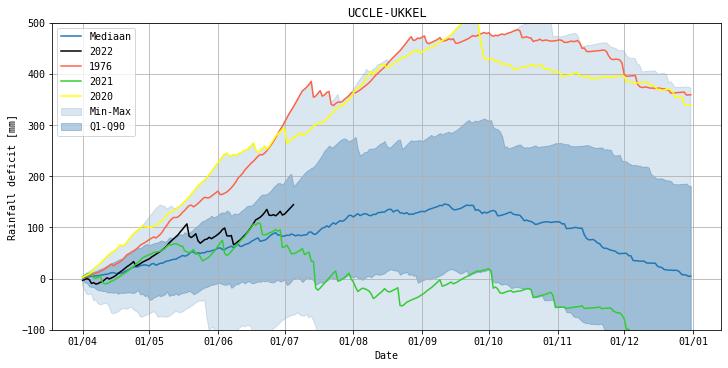

In [45]:
# Make a nice overview plot
plt.rcParams['font.family'] = 'MonoSpace'

fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)

# We start from april first in the plot which is doy: 91 (still neglecting leap years)
trunc = 91
xas = [datetime.datetime(2021, 1, 1) + datetime.timedelta(x - 1) for x in df_dd.index]
ax.fill_between(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().min(axis=1), df_dd.truncate(before=trunc).cumsum().max(axis=1), alpha=.2, color='steelblue')
ax.fill_between(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().quantile(.1, axis=1), df_dd.truncate(before=trunc).cumsum().quantile(.9, axis=1), color='steelblue', alpha=.4)
ax.plot(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().quantile(.5, axis=1))
ax.plot(xas[trunc-1:], df_dd[2022].truncate(before=trunc).cumsum(),  color='black')
ax.plot(xas[trunc-1:], df_dd[1976].truncate(before=trunc).cumsum(),  color='tomato')
ax.plot(xas[trunc-1:], df_dd[2021].truncate(before=trunc).cumsum(),  color='limegreen')
ax.plot(xas[trunc-1:], df_dd[2020].truncate(before=trunc).cumsum(),  color='yellow')
ax.grid()
ax.set_ylim([-100,500])
myFmt = mdates.DateFormatter('%d/%m')
ax.xaxis.set_major_formatter(myFmt)
ax.legend(['Mediaan', '2022', '1976', '2021', '2020', 'Min-Max', 'Q1-Q90'], loc=2)
ax.set_ylabel('Rainfall deficit [mm]')
ax.set_xlabel('Date')
ax.set_title(stations.loc[station_code, 'name'])

Note that the plots do not fully correspond to the "official" plots made by Patrick Willems. Differences might be due to:
* Inconsistencies in the data (both availability and quality)
* Inconsistencies in the calculation method being used